# 01 - Exploratory Data Analysis (EDA)
Analyze the PTB-XL dataset structure and raw signals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import os
import sys

# Ensure we can import from src
sys.path.append('..')

# Configuration
DATA_DIR = '../data/ptb-xl'
CSV_PATH = os.path.join(DATA_DIR, 'ptbxl_database.csv')

if os.path.exists(CSV_PATH):
    print(f"Reading metadata from {CSV_PATH}...")
    df = pd.read_csv(CSV_PATH, index_col='ecg_id')
    display(df.head())
else:
    print(f"File not found: {CSV_PATH}. Please download the dataset first.")

Reading metadata from ../data/ptb-xl/ptbxl_database.csv...


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


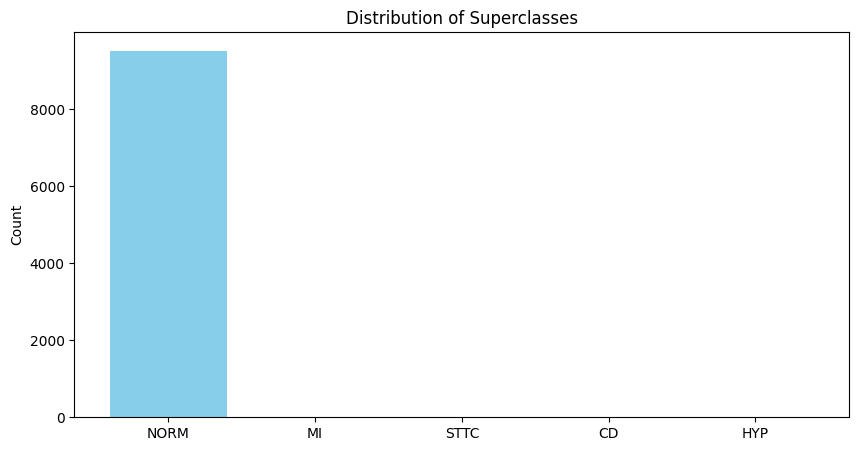

In [2]:
# 1. Label Distribution
# scp_codes are stored as string dictionaries. Let's parse them.
# We focus on the 5 Superclasses: NORM, MI, STTC, CD, HYP

classes = {'NORM': 0, 'MI': 0, 'STTC': 0, 'CD': 0, 'HYP': 0}

if 'df' in locals():
    for _, row in df.iterrows():
        try:
            data = ast.literal_eval(row['scp_codes'])
            for k in data:
                if k in classes:
                    classes[k] += 1
        except:
            pass

    plt.figure(figsize=(10, 5))
    plt.bar(classes.keys(), classes.values(), color='skyblue')
    plt.title("Distribution of Superclasses")
    plt.ylabel("Count")
    plt.show()

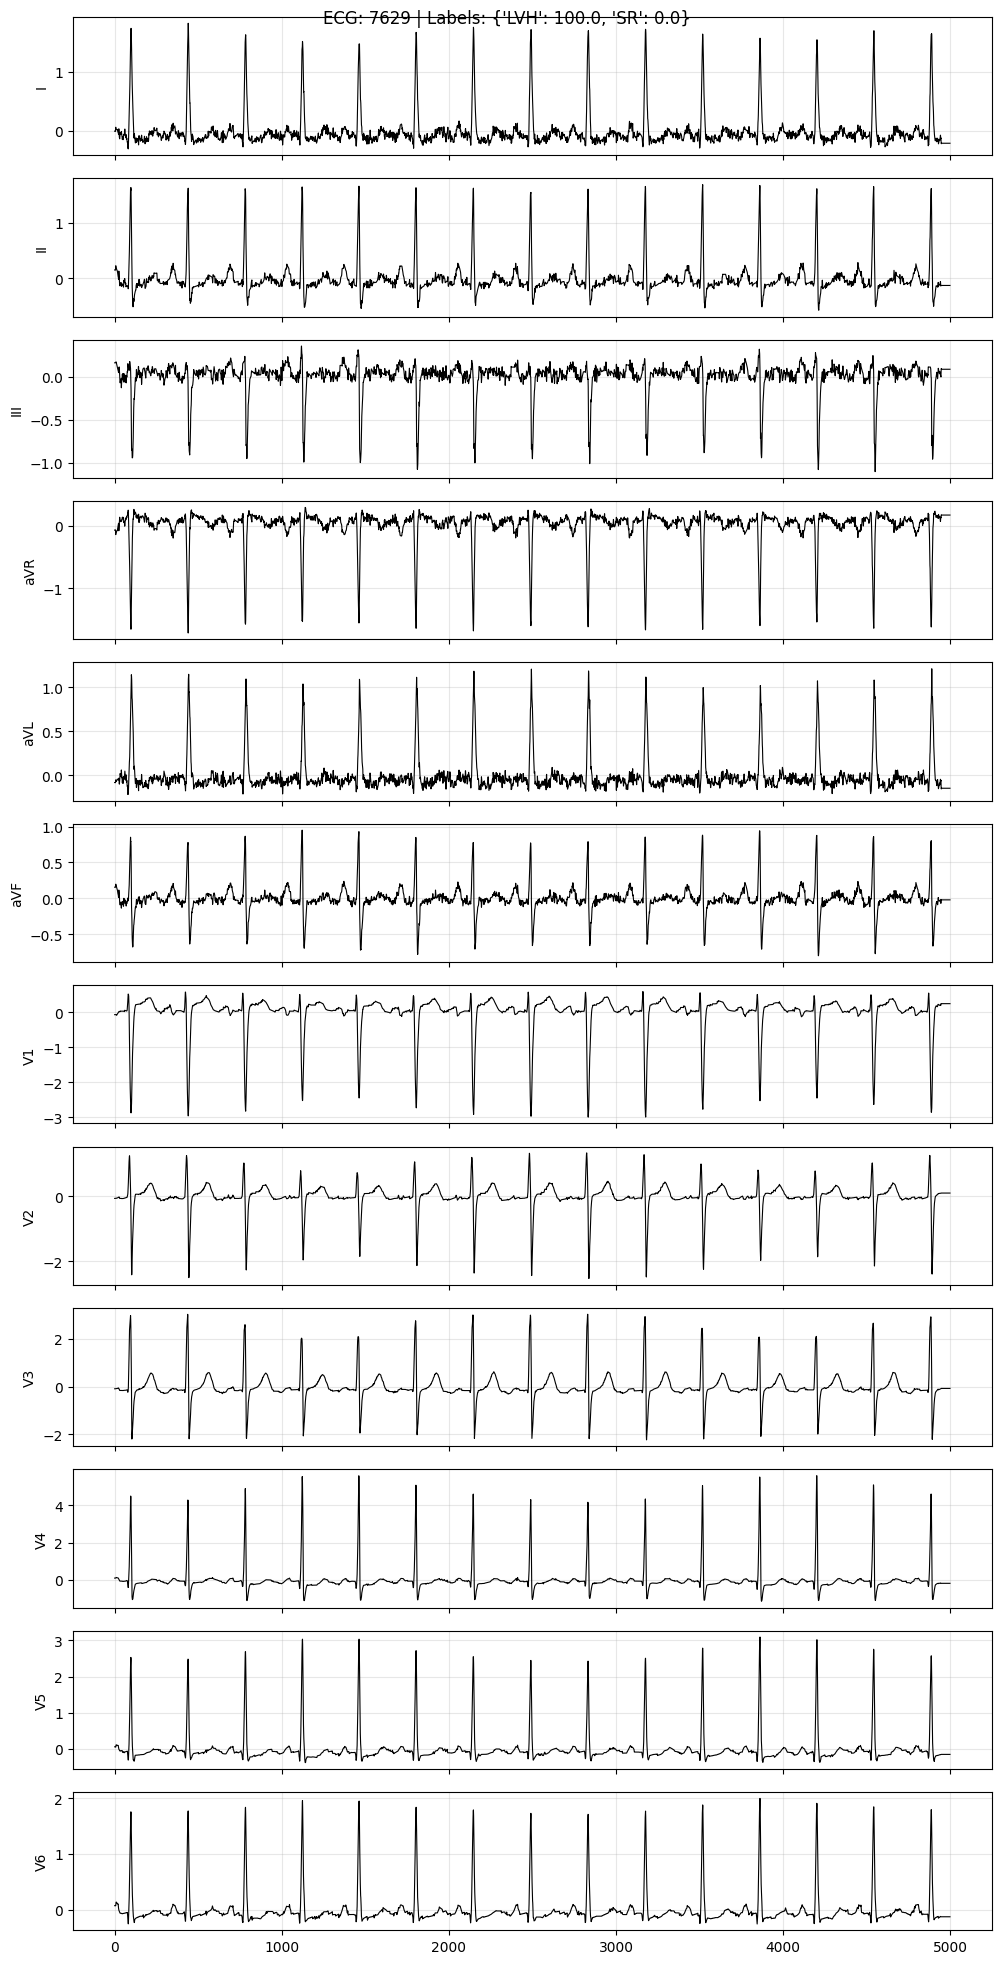

In [3]:
# 2. Visualize Random ECGs
def load_and_plot(index):
    if index not in df.index:
        print(f"Index {index} not found")
        return
        
    row = df.loc[index]
    filename = row.get('filename_hr', row.get('filename_lr')) 
    path = os.path.join(DATA_DIR, filename)
    
    try:
        # Load
        data, meta = wfdb.rdsamp(path)
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return
    
    # Plot 12 Leads
    fig, axes = plt.subplots(12, 1, figsize=(10, 20), sharex=True)
    leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    
    for i, ax in enumerate(axes):
        # Handle if data is shorter/longer or missing leads (robustness)
        if i < data.shape[1]:
            ax.plot(data[:, i], color='black', linewidth=0.8)
        ax.set_ylabel(leads[i])
        ax.grid(True, alpha=0.3)
        
    plt.suptitle(f"ECG: {index} | Labels: {row['scp_codes']}")
    plt.tight_layout()
    plt.show()

# Pick a random patient
import random
if 'df' in locals() and len(df) > 0:
    rand_id = random.choice(df.index)
    load_and_plot(rand_id)